In [1]:
## Description: Estimate Effect of member rewards/subscription program for customers on total sales
# counterfactual: If the customers did not sign up for the rewwards program how much less would they have spent?

## Source: DoWhy docs in https://www.pywhy.org/dowhy/v0.8/example_notebooks/dowhy_example_effect_of_memberrewards_program.html


In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from joblib import Parallel, delayed # for parallel processing
from toolz import partial
from dowhy import CausalModel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\arsep\anaconda3\envs\ds1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Response variable is the total spend at the end of the year (rewards program started Jan 2019)
# Creating some simulated data for our example

num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})

# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0

# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10

# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100

df

,user_id,signup_month,month,spend,treatment
0,0,0,1,477,False
1,0,0,2,496,False
2,0,0,3,453,False
3,0,0,4,441,False
4,0,0,5,490,False
...,...,...,...,...,...
119995,9999,1,8,540,True
119996,9999,1,9,500,True
119997,9999,1,10,534,True
119998,9999,1,11,476,True


In [8]:
df.shape

In [9]:
df.dtypes

user_id         int32
signup_month    int32
month           int32
spend           int32
treatment        bool
dtype: object

In [10]:
df['spend'].describe()

count    120000.000000
mean        460.251775
std          49.956851
min         302.000000
25%         424.000000
50%         461.000000
75%         494.000000
max         649.000000
Name: spend, dtype: float64

#### Naive Estimate of Average Treatment Effect (ATE)

In [13]:
treatment_avg = df.loc[df['treatment'] == True ,'spend'].mean()
control_avg = df.loc[df['treatment'] == False,'spend'].mean()

print('Treatment Average:', treatment_avg.round(4))
print('Control Average:',  control_avg.round(4))
print('Treatment Effect:', (treatment_avg - control_avg).round(4))

Treatment Average: 485.571
Control Average: 434.9528
Treatment Effect: 50.6182


### DoWhy: Graphical Causal Model Model based Inference

Rewards signup can affect the future transactions but not the ones before the signup. The transactions that happened prior to the rewards signup can be assumed to cause the rewards signup decision.

Feature engineer vars for:
1. Activity prior to the treatment (assumed a cause of the treatment): pre_spend var
2. Activity after the treatment (is the outcome of applying treatmet): post_spend var

Test for customers who signed-up in month 3
Test for ATT = The average effect on total spend for the customers that signed up for the rewards program in month i=3

In [16]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z -> treatment;
pre_spends -> treatment;
treatment -> post_spends;
signup_month -> post_spends;
signup_month -> treatment;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i

# Setting the signup month (for ease of analysis)
i = 3

df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)

print(df_i_signupmonth)


      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       486.5   415.333333
1           1             0      False       491.0   416.777778
2           5             0      False       529.0   430.666667
3           6             0      False       467.5   410.333333
4           8             0      False       492.0   412.888889
...       ...           ...        ...         ...          ...
5459     9990             0      False       515.0   425.000000
5460     9992             3       True       480.0   533.333333
5461     9994             0      False       526.0   428.888889
5462     9995             0      False       467.0   428.777778
5463     9998             0      False       511.5   423.444444

[5464 rows x 5 columns]


C:\Users\arsep\AppData\Local\Temp\ipykernel_3532\2171322604.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [37]:
df_i_signupmonth.shape

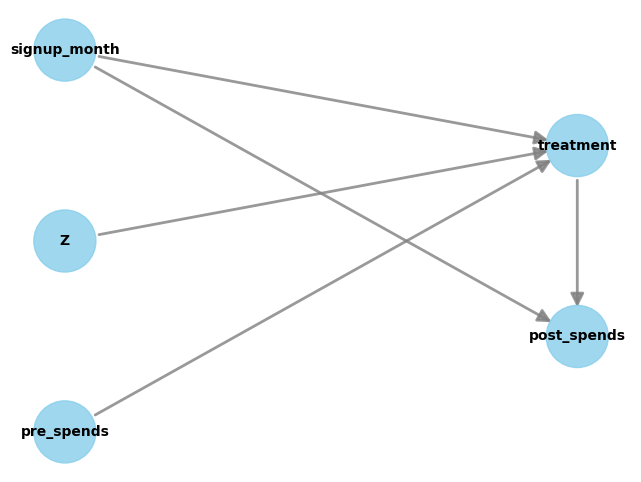

In [18]:
model = CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")

model.view_model()

In [20]:
df['treatment'].unique()

array([False,  True])

In [49]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True) # proceed_when_unidentifiable ignore any unobserved confounding
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[pre_spends  Z]              ⎝d[pre_spends  Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,Z})
Estimand assumption 2, Exclusion: If we remove {pre_spends,Z}→{treatment}, then ¬({pre_spends,Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Distance Matching

In [50]:
causal_estimate_dmatch  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

print('Distance Matching ATE:', round(causal_estimate_dmatch.value,4))

Distance Matching ATE: 98.0097


#### Linear Regression

In [51]:
causal_estimate_linreg  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.linear_regression',
    test_significance=True,
    target_units='att')

print('Linear Regression ATT:', round(causal_estimate_linreg.value,4))

Linear Regression ATT: 10.1087


#### Propensity Score Matching

In [52]:
causal_estimate_pmatching  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='att')

print('Propensity Score Stratification ATT:', round(causal_estimate_pmatching.value,4))

Propensity Score Stratification ATT: 105.6736


In [53]:
print(causal_estimate_pmatching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 105.67364117364119



#### Propensity Score Weighting

In [54]:
causal_estimate_weighting  = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='att',
    method_params={"weighting_scheme":"ips_weight"})

print('Weighting ATT:', round(causal_estimate_weighting.value,4))

Weighting ATT: 101.0866


### Refuting the Estimate: Robustness Tests

Test the estimators against refutation tests (p-value < .05).
Cannot verify that the estimate if correct, but can falisfy if the expected behavior is violated.
Types:
Invariant Transformations = Changes in the data that should not change the estimate (e.g., random common cause, data subset)
Nullifying Transformations = After the data change, the causal estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test (e.g., placebo treatment).

There are many important variables affecting signup and total spend that are missing (e.g., the type of products bought, length of a user's account, geography, etc.). Test for this.

In [55]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand,causal_estimate_pmatching,method_name="random_common_cause",random_seed=1)
print(res_random)

Refute: Add a random common cause
Estimated effect:105.67364117364119
New effect:105.67364117364123
p value:1.0



In [57]:
# Replacing treatment with a random placebo variable
# estimate should go to 0
res_placebo=model.refute_estimate(identified_estimand,causal_estimate_pmatching,method_name="placebo_treatment_refuter",placebo_type="permute",num_simulations=20,random_seed=1)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:105.67364117364119
New effect:4.215127465127484
p value:3.0543025014669563e-07



In [58]:
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand,causal_estimate_pmatching,method_name="data_subset_refuter",subset_fraction=.9,random_seed=1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:105.67364117364119
New effect:101.80520945749369
p value:0.52



### Limitations

Left-censoring and right-censoring
Left-censoring = If a customer signs up in the first month, we do not have enough transaction history to match them to similar customers who did not sign up (and thus apply the backdoor identified estimand). 
Right-censoring = If a customer signs up in the last month, we do not enough future (post-treatment) transactions to estimate the outcome after signup.

Issues: even if the effect of signup was the same across all months, the estimated effects may be different by month of signup, due to lack of data (and thus high variance in estimated pre-treatment or post-treatment transactions activity)

### Scrape Code

#### Propensity Score Matching

In [61]:
# causal_estimate_pstrat  = model.estimate_effect(
#    identified_estimand=identified_estimand,
#    method_name='backdoor.propensity_score_stratification',
#    target_units='att',
#    method_params={'num_strata':100,'clipping_threshold':10})

# print('Propensity Score Stratification ATT:', round(causal_estimate_pstrat.value,4))
